# Import libraries

In [1]:
# import standard libraires
from joblib import dump, load
import os.path
# import third-part libraries
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
# import local libraries

# Import data

In [22]:
# import data ready from eda
all_data = pd.read_csv('movies_metadata_eda.csv')

In [23]:
data = all_data.drop(columns = ['id', 'original_title'])

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42664 entries, 0 to 42663
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   adult                        42664 non-null  int64  
 1   budget                       42664 non-null  float64
 2   popularity                   42664 non-null  float64
 3   revenue                      42664 non-null  float64
 4   runtime                      42664 non-null  float64
 5   video                        42664 non-null  int64  
 6   vote_average                 42664 non-null  float64
 7   vote_count                   42664 non-null  float64
 8   release_year                 42664 non-null  int64  
 9   release_month                42664 non-null  int64  
 10  roi                          42664 non-null  float64
 11  revenue_norm_max             42664 non-null  float64
 12  year_revenue_max             42664 non-null  float64
 13  budget_norm_max 

# Feature selection

In [25]:
# separate exo and indogeneous variables, We choose to predict popularity
# this means we need to drop all columns that contain the revenue and votes 
data = data.astype(np.float64)
target_label = 'popularity' #'revenue_norm_mean'
data = data.drop(columns = [
                            'revenue', 
                            'vote_average', 
                            'vote_count', 
                            'roi',
                            'revenue_norm_max', 
                            'revenue_norm_mean',
                           ]
                ) # ['revenue', 'roi', 'revenue_norm_max']
X, y = data.drop(columns = target_label), data[[target_label]]
y = y[target_label]

# normalize inputs
X_trans = MinMaxScaler().fit_transform(X)
X_trans = pd.DataFrame(data = X_trans, columns = X.columns, index = X.index)

# keep a eye on number of accepted features
feature_score = pd.DataFrame(index = X.columns)

## Pearson correlation

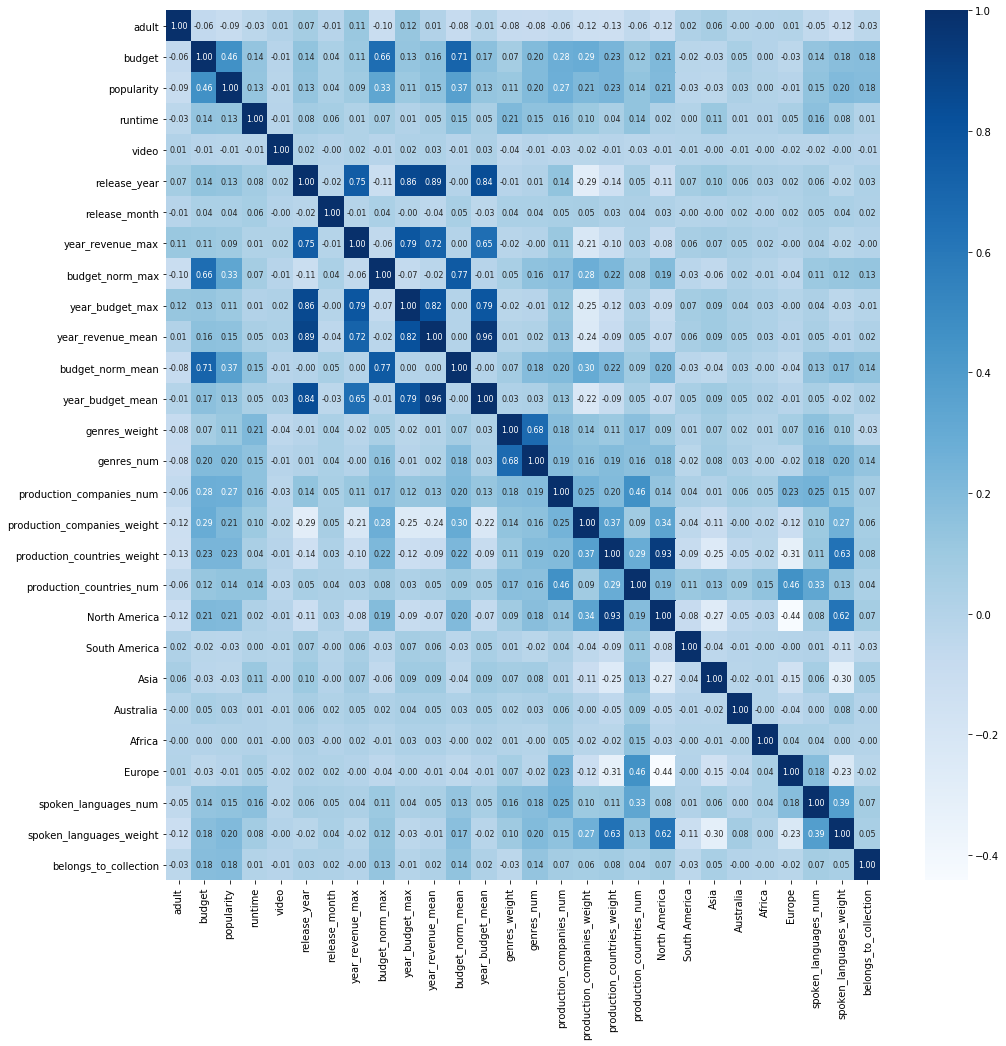

In [26]:
# since all columns are numeric, we can compute the pearsoncorrelation 
fig, ax = plt.subplots(figsize = (16, 16))
pearson = data.corr()
sns.heatmap(pearson, annot = True, cmap = plt.cm.Blues, annot_kws = {'size': 8}, fmt = '.2f')

If we look under revenue_norm_mean, we see that the following columns have a pearson correlation above apprimately 0.20

In [27]:
feature_score['pearson'] = np.nan
feature_score['pearson'] = pearson[target_label].apply(lambda x: True if x > 0.19 else False)
num_feat = feature_score['pearson'].sum()
print(feature_score)
print(num_feat)

                             pearson
adult                          False
budget                          True
runtime                        False
video                          False
release_year                   False
release_month                  False
year_revenue_max               False
budget_norm_max                 True
year_budget_max                False
year_revenue_mean              False
budget_norm_mean                True
year_budget_mean               False
genres_weight                  False
genres_num                      True
production_companies_num        True
production_companies_weight     True
production_countries_weight     True
production_countries_num       False
North America                   True
South America                  False
Asia                           False
Australia                      False
Africa                         False
Europe                         False
spoken_languages_num           False
spoken_languages_weight         True
b

## F-value selection

In [28]:
kbest_selector = SelectKBest(score_func = f_regression, k = num_feat)
kbest_selector = kbest_selector.fit(X_trans, y)
kbest = kbest_selector.get_support()
# add to feature_score
feature_score['f_value'] = np.nan
feature_score['f_value'] = kbest

## RFE selection

In [9]:
temp_est = SVR(kernel = 'linear')
rfe = RFE(temp_est, n_features_to_select = 7, step = 1)
rfe = rfe.fit(X_trans, y)
rfe_best = rfe.get_support()

In [10]:
feature_score['rfe'] = np.nan
feature_score['rfe'] = rfe_best

In [11]:
feature_score['total_score'] = feature_score[['pearson', 'f_value', 'rfe']].sum(axis = 1)
feature_score

,pearson,f_value,rfe,total_score
adult,False,False,False,0
budget,True,True,True,3
runtime,False,False,True,1
video,False,False,False,0
release_year,False,False,False,0
release_month,False,False,False,0
year_revenue_max,False,False,False,0
budget_norm_max,True,True,False,2
year_budget_max,False,False,False,0
year_revenue_mean,False,False,False,0


## Best features

In [29]:
best_feature = feature_score.sort_values(by = 'total_score', ascending = False)[:num_feat]
best_feature

KeyError: 'total_score'

## Filter X of best features

In [30]:
X_trans_best = X_trans[best_feature.index.values]
X_trans_best

NameError: name 'best_feature' is not defined

In [17]:
X_trans_best.to_csv('movies_metadata_eda_x_trans_best.csv', index = False)

# SVR with CV

In [177]:
X_trans_best = pd.read_csv('movies_metadata_eda_x_trans_best.csv')

In [178]:
# seperate x data into training and test sets, we take 30% test and 70% train
X_train, X_test, y_train, y_test = train_test_split(X_trans_best, y, test_size = 0.3, random_state = 45) #45

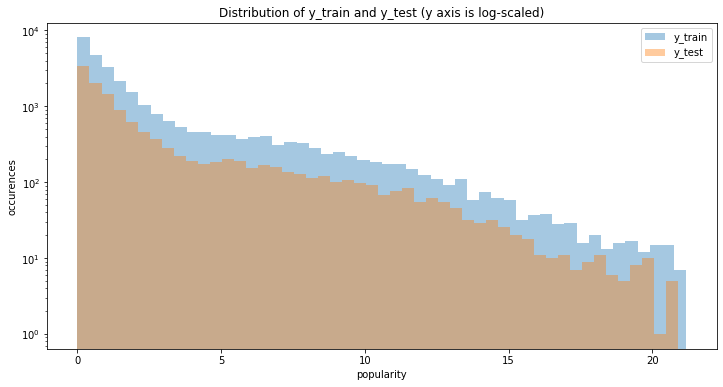

In [179]:
# check if y_train and y_test are equally distributed
fig, ax = plt.subplots(figsize = (12, 6))
# remove outliers using z-score
to_plot_train = y_train[(np.abs(stats.zscore(y_train)) < 3)]
to_plot_test = y_test[(np.abs(stats.zscore(y_test)) < 3)]
g = sns.distplot(to_plot_train, kde = False, ax = ax, label = 'y_train')
g.set_yscale('log')
sns.distplot(to_plot_test, kde = False, ax = ax, label = 'y_test')
g.set_ylabel('occurences')
g.set_title('Distribution of y_train and y_test (y axis is log-scaled)')
g.legend()

In [180]:
# define grid of hyperparameters for SVR
param_grid = {'C': [10, 100, 1000], 
              'gamma': [0.1, 0.01, 0.001],
              'kernel': ['rbf']}
scores = ['r2']
regressors = {k: None for k in scores}
results = {k: None for k in scores}

In [181]:
filename_regressors = 'svrcv_regressors_popularity_2.joblib'
filename_results = 'svrcv_results_popularity_2.joblib'

if not os.path.isfile(filename_regressors) and not os.path.isfile(filename_results):

    # perform grid search for all score
    for s in scores:
        # create grid search for hyperparameters
        reg = GridSearchCV(SVR(), param_grid, scoring = s) # we use default 5-fold cross validation
        # fit
        reg.fit(X_train, y_train)
        # keep fitted regressor
        regressors[s] = reg
        # get score and parameters and create a dataframe of results
        means = reg.cv_results_['mean_test_score']
        params = reg.cv_results_['params']
        index = pd.MultiIndex.from_frame(pd.DataFrame(params))
        res = pd.DataFrame(data = means, index = index)
        # store results
        results[s] = res

    # save results in pickle file
    dump(regressors, filename_regressors)
    dump(results, filename_results)
    
else:
    
    regressors = load(filename_regressors)
    results = load(filename_results)

In [182]:
all_results = pd.DataFrame()
for k, _ in results.items():
    if k == 'r2':
        results[k] = results[k].rename(columns = {0: k})
        all_results = pd.concat([all_results, results[k]], axis = 1)

In [183]:
for k, _ in regressors.items():
    print(k)
    print(regressors[k].best_params_)

r2
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [184]:
# take sum of scores and sort from best to worst score
#all_results['total_score'] = np.nan
#all_results['total_score'] = all_results[scores[0:1]].sum(axis = 1)
all_results = all_results.sort_values(by = 'r2', ascending = False)

In [185]:
all_results

r2
C    gamma kernel          
1000 0.100 rbf     0.280716
     0.010 rbf     0.274308
100  0.100 rbf     0.272694
10   0.100 rbf     0.270862
100  0.010 rbf     0.264539
1000 0.001 rbf     0.256753
10   0.010 rbf     0.226992
100  0.001 rbf     0.223365
10   0.001 rbf     0.142456

In [186]:
# new using trained estimators
regr_r2 = regressors['r2']
r2_score = regr_r2.score(X_test, y_test)
r2_score

0.2692285413822072

# Decision trees

In [187]:
param_grid = {'min_samples_split': [2, 5, 10, 50, 100, 500, 1000, 5000], 
              'max_depth': [10, 50, 100, 500, 1000, 5000, 10000],
              'min_samples_leaf': [1, 10, 50, 100, 500, 1000]
             }

reg_tree = GridSearchCV(DecisionTreeRegressor(), param_grid)
reg_tree = reg_tree.fit(X_train, y_train)

In [188]:
print(reg_tree.best_params_)
reg_tree.score(X_test, y_test)

{'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 2}


0.29436791848340726

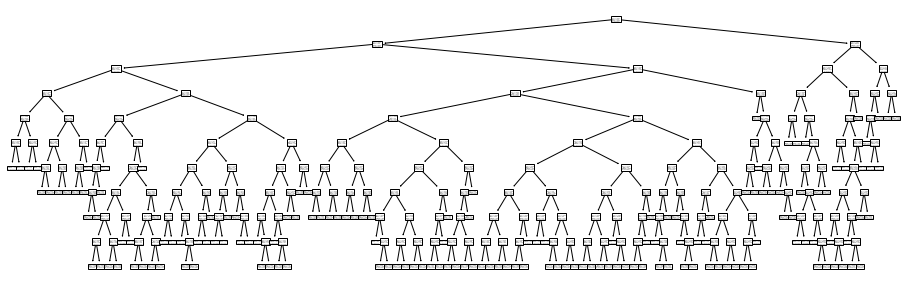

In [189]:
temp = reg_tree.best_estimator_
fig, ax = plt.subplots(figsize = (16, 5))
_ = tree.plot_tree(temp, ax = ax)

# Baggign on SVR

In [190]:
# use bagging
reg_bag = BaggingRegressor(SVR(C = 1000, gamma = 0.1, kernel = 'rbf'), n_estimators = 100)
reg_bag = reg_bag.fit(X_train, y_train)

In [191]:
reg_bag.score(X_test, y_test)

0.2685761849222025

## BAgging on tree 

In [192]:
reg_bag_2 = BaggingRegressor(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 100, min_samples_split = 2
                                                  ), n_estimators = 100)
reg_bag_2 = reg_bag_2.fit(X_train, y_train)

In [193]:
reg_bag_2.score(X_test, y_test)

0.31283824508555214

# Results